# Learning to Learn w\ Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_0.ipynb)

This it the first jupyter notebook used to familiarize with _Pennylane_ and _RNNs_ and _LSTMs_.

At first, the QAOA example for MAXCUT will be implemented.

**Run cell below only if using this notebook in Colab**  
Installing required dependencies and packages

In [ ]:
IS_COLAB = False
if IS_COLAB:
    !pip install --upgrade qiskit
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

import tensorflow as tf

import networkx as nx
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm

Set the seed for reproducibility of results

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Generation of data: graphs

Generation of a rangom graph $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of creation of an edge between two nodes

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

Sample of a generted graph with 7 nodes and 11 edges (p=0.43)


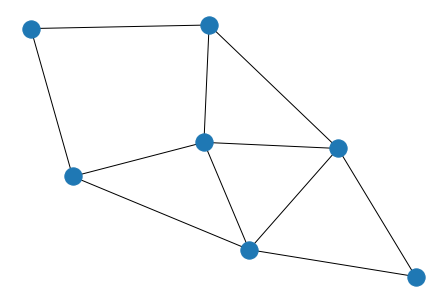

In [281]:
# Define parameters of the graph
n_graphs = 10
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a generted graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

In [283]:
nx.to_edgelist(graphs[0])

EdgeDataView([(0, 2, {}), (0, 3, {}), (0, 4, {}), (0, 6, {}), (1, 2, {}), (1, 4, {}), (1, 5, {}), (2, 3, {}), (2, 4, {}), (4, 6, {}), (5, 6, {})])

## Creating QAOA circuit

In [352]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit.tf", wires=7, analytic=True)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=2, graph = None):
    
    n_wires = len(graph.nodes)
    
    # unitary operator U_B with parameter beta
    def U_B(beta):
        for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

    # unitary operator U_C with parameter gamma
    def U_C(gamma):
        for edge in graph.edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])
            
    def comp_basis_measurement(wires):
        n_wires = len(wires)
        return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)    
    
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [354]:
circuit([1,1],[1,1], edge = 2,graph = graphs[0])

InvalidArgumentError: Input to reshape is a tensor with 16 values, but the requested shape has 4 [Op:Reshape]

In [330]:
def qaoa_from_graph(graph):
    """
    Creates a QAOA circuit instance of the MaxCut problem given a graph. Has nested function definitions needed for
    the creation of the circuit. When called, it instantiate a the structure of the circuit given the input graph,
    and outputs a function which needs only the parameters to be evaluated. 
    
    Args
    ------
    graph: Graph coming generated with networkx.
    
    Return
    ------
    hamiltonian: A function which, given params as input, evaluates the cost function of the 
                 QAOA qautntum circuit.
    
    """
    
    graph = graph.numpy()
    
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, 2, params[0], params[1])
     
    # Evaluates the cost function
    def hamiltonian(params, **kwargs):
        dev = qml.device('default.qubit', wires=len(graph.nodes))
        cost = qml.VQECost(circuit, cost_h, dev, interface="tf")
        return cost(params)
    
    return hamiltonian

#### Check the functioning

In [331]:
# Define some paramenters, in the form [gamma, alpha]
x = tf.Variable(np.array([[1.,1.],[2.,2.]]))
#x = np.array([[1.,1.],[2.,2.]])

# Create an instance of a QAOA circuit given a graph
circ = qaoa_from_graph(graph = graphs[3])

# Evaluate the cost function given some angles for the QAOA instance just created
circ(x)

AttributeError: 'Graph' object has no attribute 'numpy'

#### Check evaluation of gradients

In [157]:
x = tf.Variable(np.array([[1.,1.],[2.,2.]]))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
step = 1

for _ in range(step):
    with tf.GradientTape() as tape:
        loss = circ(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    
print(f"Final cost function: {circ(x).numpy()}\nOptimized angles: {x.numpy()}")

Final cost function: [-5.5176096]
Optimized angles: [[1.1845222  0.95957392]
 [1.79830495 2.39530904]]


## Recurrent Neural Network

In [348]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p = 2):
        super(QRNN, self).__init__()
        self.cell = tf.keras.layers.LSTMCell(2*p)

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]
        graph = inputs[4]
        
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        new_params, [new_h, new_c] = self.cell(new_input, states = [prev_h, prev_c])
        
        _params = tf.reshape(new_params, shape = (2,2))
        
        print(tf.executing_eagerly())
        
        exp_func = qaoa_from_graph(graph)
        
        #new_cost = prev_cost 
        new_cost = tf.reshape(tf.cast(exp_func(_params), dtype = tf.float32), shape = (1,1))
    
        return [new_cost, new_params, new_h, new_c, graph]

In [236]:
inp_cost = tf.random.uniform(shape=(1,1), dtype = tf.float32)
inp_params = tf.random.uniform(shape=(1,4), dtype = tf.float32)

tf.keras.layers.concatenate([inp_cost, inp_params])

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.07319033, 0.5340085 , 0.5080675 , 0.16714239, 0.27784133]],
      dtype=float32)>

In [323]:
rnn0 = QRNN(graphs[0])
rnn1 = QRNN(graphs[0])
rnn1 = QRNN(graphs[0])

inp_cost = tf.random.uniform(shape=(1,1), dtype = tf.float32)
inp_params = tf.random.uniform(shape=(1,4), dtype = tf.float32)
inp_h = tf.random.uniform(shape=(1,4), dtype = tf.float32)
inp_c = tf.random.uniform(shape=(1,4), dtype = tf.float32)

out0 = rnn0([inp_cost, inp_params, inp_h, inp_c])
out1 = rnn1(out0)

TypeError: unsupported operand type(s) for *: 'int' and 'Graph'

In [311]:
x.numpy()

array([[1., 1.],
       [2., 2.]])

In [349]:
n_qubits = 7

rnn0 = QRNN()
rnn1 = QRNN()

inp_cost = tf.keras.layers.Input(shape=(1,))
inp_params = tf.keras.layers.Input(shape=(4,))
inp_h = tf.keras.layers.Input(shape=(4,))
inp_c = tf.keras.layers.Input(shape=(4,))
inp_graphs = tf.keras.layers.Input(shape=(7,7,))

out0 = rnn0([inp_cost, inp_params, inp_h, inp_c, inp_graphs])
out1 = rnn1(out0)

False


TypeError: in user code:

    <ipython-input-348-d1d3c1701995>:20 call  *
        exp_func = tf.py_function(qaoa_from_graph, graph)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)

    TypeError: eager_py_func() missing 1 required positional argument: 'Tout'


In [171]:
print(out0)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.6870933]], dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01711032,  0.1122964 ,  0.17498289,  0.25270376]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01711032,  0.1122964 ,  0.17498289,  0.25270376]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02511675,  0.33154297,  0.32523316,  0.4970109 ]],
      dtype=float32)>]


In [18]:
tf.zeros(shape=(4,1))

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [59]:
cell0 = tf.keras.layers.LSTMCell(4)
cell1 = tf.keras.layers.LSTMCell(4)
cell2 = tf.keras.layers.LSTMCell(4)

output, [h, c] = cell0(tf.ones(shape=(1,5)), states = [tf.zeros(shape=(1,4)), tf.zeros(shape=(1,4))])
#output, [h, c] = cell1(output, states = [h, c])
#output, [h, c] = cell2(output, states = [h, c])


print(output, h, c)

tf.Tensor([[-0.17202593 -0.20535323  0.04497509 -0.02444211]], shape=(1, 4), dtype=float32) tf.Tensor([[-0.17202593 -0.20535323  0.04497509 -0.02444211]], shape=(1, 4), dtype=float32) tf.Tensor([[-0.2699196  -0.3037619   0.10269862 -0.05725596]], shape=(1, 4), dtype=float32)


In [53]:
output[0,:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.15247668, -0.00897596], dtype=float32)>

In [34]:
cell = tf.keras.layers.LSTMCell(4)
self.expectation = qaoa_from_graph(graph)

f call(self, inputs):
prev_cost = inputs[0]
prev_params = inputs[1]
prev_h = inputs[2]
prev_c = inputs[3]

new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
new_params, new_h, new_c = self.cell(new_input, state = [prev_h, prev_c])

new_cost = self.expectation([new_params[:2], new_params[2:]])

return [new_cost, new_params, new_h, new_c]

SyntaxError: invalid syntax (<ipython-input-34-8abbfdd40d59>, line 4)

In [10]:
cost_inp = tf.keras.Input(shape=(1,))
params_inp = tf.keras.Input(shape=(2,2))
h_inp = tf.keras.Input(shape=(4,)) # it has the shape (batch, units)
c_inp = tf.keras.Input(shape=(4,))

In [12]:
rnn0 = QRNN(graphs[0])

TypeError: ('Keyword argument not understood:', 'return_state')

In [ ]:
# Generate random MaxCut instances as training data.
N_QUBITS = 10

# For a more accurate optimizer on testing data, increase N_POINTS
N_POINTS = 500
circuits, symbols, ops = generate_data(N_QUBITS, N_POINTS)
circuit_tensor = tfq.convert_to_tensor(circuits)
ops_tensor = tfq.convert_to_tensor(ops)

# Unroll the RNN through time.
state_inp = tf.keras.Input(shape=(25,))
params_inp = tf.keras.Input(shape=(2,))
exp_inp = tf.keras.Input(shape=(25,))

op_inp = tf.keras.Input(shape=(1,), dtype=tf.dtypes.string)
circuit_inp = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

rnn_0 = QRNN(symbols)
rnn_1 = QRNN(symbols)
rnn_2 = QRNN(symbols)
rnn_3 = QRNN(symbols)
rnn_4 = QRNN(symbols)
output_0 = rnn_0([circuit_inp, op_inp, state_inp, params_inp, exp_inp])
output_1 = rnn_1(output_0)
output_2 = rnn_2(output_1)
output_3 = rnn_3(output_2)
output_4 = rnn_4(output_3)

In [38]:
features = 2
inputs = tf.keras.Input(shape=(None, features), batch_size=1)
outputs = tf.keras.layers.LSTM(units=features, 
                               stateful=True, 
                               return_sequences=True, #just to keep a nice output shape even with length 1
                               input_shape=(None,features))(inputs) 
    #units = features because we want to use the outputs as inputs
    #None because we want variable length

#output_shape -> (batch_size, steps, units) 

In [39]:
#important, we're starting new sequences, not continuing old ones:
model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [40]:
model.predict(input_data)

array([[[ 0.1565638 , -0.06958422]]], dtype=float32)

In [46]:
input_data = tf.ones(shape=(10,1,2))
model.reset_states()

output_sequence = []
last_step = input_data
for i in range(5):

    new_step = model.predict(last_step)
    output_sequence.append(new_step)
    last_step = new_step

#end of the sequences
model.reset_states()

In [47]:
model.compile(optimizer="Adam", loss="mse")

In [52]:
tf.ones(shape=(10,1,2))

<tf.Tensor: shape=(10, 1, 2), dtype=float32, numpy=
array([[[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]],

       [[1., 1.]]], dtype=float32)>

In [51]:
model.fit(tf.ones(shape=(10,1,2)),tf.zeros(shape=(10,1,2)), epochs = 80)

Epoch 1/80
1/1 [==============================] - 0s 793us/step - loss: 0.0325
Epoch 2/80
1/1 [==============================] - 0s 791us/step - loss: 0.0319
Epoch 3/80
1/1 [==============================] - 0s 716us/step - loss: 0.0314
Epoch 4/80
1/1 [==============================] - 0s 1ms/step - loss: 0.0309
Epoch 5/80
1/1 [==============================] - 0s 921us/step - loss: 0.0304
Epoch 6/80
1/1 [==============================] - 0s 1ms/step - loss: 0.0299
Epoch 7/80
1/1 [==============================] - 0s 794us/step - loss: 0.0294
Epoch 8/80
1/1 [==============================] - 0s 902us/step - loss: 0.0289
Epoch 9/80
1/1 [==============================] - 0s 1ms/step - loss: 0.0285
Epoch 10/80
1/1 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 11/80
1/1 [==============================] - 0s 912us/step - loss: 0.0275
Epoch 12/80
1/1 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 13/80
1/1 [==============================] - 0s 812us

In [31]:
output_sequence

[array([[[ 0.12212959, -0.09125746]]], dtype=float32),
 array([[[ 0.06739943, -0.09311913]]], dtype=float32),
 array([[[ 0.01964027, -0.05808432]]], dtype=float32),
 array([[[-0.00209543, -0.03724273]]], dtype=float32),
 array([[[-0.01082195, -0.02438239]]], dtype=float32)]

In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(1, None, 2)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 2)              40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [147]:
def generate_dataset(num_qubits, num_data):
    p_edge = 3./num_qubits
    circs = []
    for _ in range(num_data):
        random_graph = nx.gnp_random_graph(num_qubits, p = p_edge)
        circ = qaoa_from_graph(random_graph)
        circs.append(circ)
    return circs

In [148]:
circs = generate_dataset(5, 10)

## Mapping of Graph to QAOA anstaze

How to create a circuit in Pennylane

In [88]:
dev = qml.device('default.qubit', wires=2, shots=1024, analytic=False)

@qml.qnode(dev)
def circuit():
    qml.PauliX(1)
    qml.Hadamard(0)
    return qml.expval(qml.PauliZ(1))

circuit()
print(circuit.draw())

 0: ──H──┤     
 1: ──X──┤ ⟨Z⟩ 



In [180]:
# Transverse field
def U_x(eta, n_wires = None):
    for wire in range(n_wires):
        qml.RX(2 * eta, wires = wire)

# Actual hamiltonian
def U_C(gamma, graph = None):
    for edge in graph.edges():
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def qaoa_from_graph(alphas, betas, graph = None, p = None):
    n_qubits = len(graph.nodes)
    
    # All qubits to |+> state
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Repeat QAOA ansatze p times
    for n_layers in range(p):
        for e in graph.edges():
            qml.CZ(wires = [e[0], e[1]])
            
    # Final measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

dev = dev = qml.device('default.qubit', wires=7, shots=1024, analytic=False)

qnode = qml.QNode(qaoa_from_graph, dev)

qnode(0., 0., graph = graphs[0], p = 1)

print(qnode.draw())

 0: ──H──╭C──╭C──────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰Z──│───╭C──────╭C──────╭C──────────────────┤ ⟨Z⟩ 
 2: ──H──────│───│───╭C──│───╭C──│───────╭C──────────┤ ⟨Z⟩ 
 3: ──H──────╰Z──╰Z──╰Z──│───│───│───╭C──│───────────┤ ⟨Z⟩ 
 4: ──H──────────────────╰Z──╰Z──│───╰Z──│───╭C──────┤ ⟨Z⟩ 
 5: ──H──────────────────────────│───────│───│───╭C──┤ ⟨Z⟩ 
 6: ──H──────────────────────────╰Z──────╰Z──╰Z──╰Z──┤ ⟨Z⟩ 

